In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
import os, cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from torch_snippets import *
import matplotlib.pyplot as plt
import selectivesearch
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class ImagesData(Dataset):
    def __init__(self, df, images_dir):
        self.df = df
        self.images_dir = images_dir
        self.unique_images = df['ImageID'].unique().tolist()
    
    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, index):
        img_id = self.unique_images[index]
        img_path = os.path.join(self.images_dir, img_id + '.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        filtered = self.df.loc[self.df['ImageID'] == img_id, :]
        boxes = (filtered[['XMin', 'YMin', 'XMax', 'YMax']].values * np.array([w, h, w, h])).astype(np.uint16).tolist()
        labels = filtered['LabelName'].tolist()
        return img, boxes, labels, img_path

In [3]:
df = pd.read_csv('./archive/df.csv')
dataset = ImagesData(df, './archive/images/images')

In [4]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < 0.05 * img_area: continue
        if r['size'] > img_area: continue

        candidates.append(list(r['rect']))
    
    return candidates

def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    width = (x2 - x1)
    height = (y2 - y1)

    if (width<0) or (height <0):
        return 0.0

    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)

    return iou


In [5]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="skimage.feature.texture")

N = 500
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

for i, [img, bbs, labels, img_path] in enumerate(dataset):
    if i == N:
        break
    H, W, C = img.shape
    candidates = extract_candidates(img)
    ious, rois, clss, deltas = [], [], [], []
    for candidate in candidates:
        curr_iou = []
        for bb in bbs:
            iou = extract_iou(bb, candidate)
            curr_iou.append(iou)
        ious.append(curr_iou)
    
    for j, candidate in enumerate(candidates):
        cx, cy, *dim = candidate
        cX = cx + dim[0]
        cY = cy + dim[1]
        candidate_ious = ious[j]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x, _y, _X, _Y = bbs[best_iou_at]

        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else:
            clss.append('background')

        delta = np.array([_x - cx, _y - cy, _X - cX, _Y - cY]) / np.array([W, H, W, H])
        deltas.append(delta)
        rois.append((cx, cy, cX, cY) / np.array([W, H, W, H]))
    
    FPATHS.append(img_path)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

In [6]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for l, t in enumerate(targets['label'].unique())}
target2label = {t:l for l, t in label2target.items()}
background_class = target2label['background']

In [7]:
normalize= transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

def decode(y):
    _, preds = y.max(-1)
    return preds

In [8]:
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
        self.gtbbs = gtbbs

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, index):
        fpath = str(self.fpaths[index])
        image = cv2.imread(fpath, 1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape

        gtbbs = self.gtbbs[index]
        labels = self.labels[index]
        deltas = self.deltas[index]
        rois = self.rois[index]

        bbs = (np.array(rois) * np.array([W, H, W, H])).astype(np.uint16)
        crops = [image[y: Y, x: X] for (x, y, X, Y) in bbs]
        
        return image, crops, bbs, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        inputs, labels, deltas = [], [], [] 
        for i in range(len(batch)):
            image, image_crops, image_bbs, image_labels, image_deltas, image_gtbbs, image_path = batch[i]
            crops = [cv2.resize(crop, (224, 224)) for crop in image_crops]
            crops = [preprocess_image(crop / 255.0)[None] for crop in crops]
            
            inputs.extend(crops)
            labels.extend([target2label[l] for l in image_labels])
            deltas.extend(image_deltas)

        
        inputs = torch.cat(inputs).to(device)
        labels = torch.tensor(labels).long().to(device)
        deltas = torch.tensor(deltas).float().to(device)

        return inputs, labels, deltas

In [24]:
train_n = 9 * N // 10
train_ds = RCNNDataset(FPATHS[:train_n], ROIS[:train_n], CLSS[:train_n], DELTAS[:train_n], GTBBS[:train_n])
test_ds = RCNNDataset(FPATHS[train_n:], ROIS[train_n:], CLSS[train_n:], DELTAS[train_n:], GTBBS[train_n:])

BATCH_SIZE = 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_ds.collate_fn, drop_last=True)

In [33]:
vgg_backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25_088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 4),
            nn.Tanh()
        )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    
    def forward(self, x):
        feat = self.backbone(x)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
        
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs = torch.where(labels != 0)[0]
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss, regression_loss
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss, regression_loss

In [34]:
def train_batch(inputs, model, optimizer, criterion):
    inputs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(inputs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    inputs, clss, deltas = inputs
    model.eval()
    _clss, _deltas = model(inputs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [ ]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = torch.optim.SGD(rcnn.parameters(), lr=1e-3)
epochs = 5
log = Report(epochs)

for epoch in range(epochs):
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/len(train_loader))
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')
    
    val_losses, val_accs = [], []
    for ix, inputs in enumerate(test_loader):
        loss, loc_loss, regr_loss, accs = validate_batch(inputs, rcnn, criterion)
        val_losses.append(loss.item())
        val_accs.append(accs.mean())
    
    print(f"\nEpoch {epoch+1}/{epochs} | "
          f"Val Loss: {np.mean(val_losses):.3f} | "
          f"Val Acc: {np.mean(val_accs):.3f}")


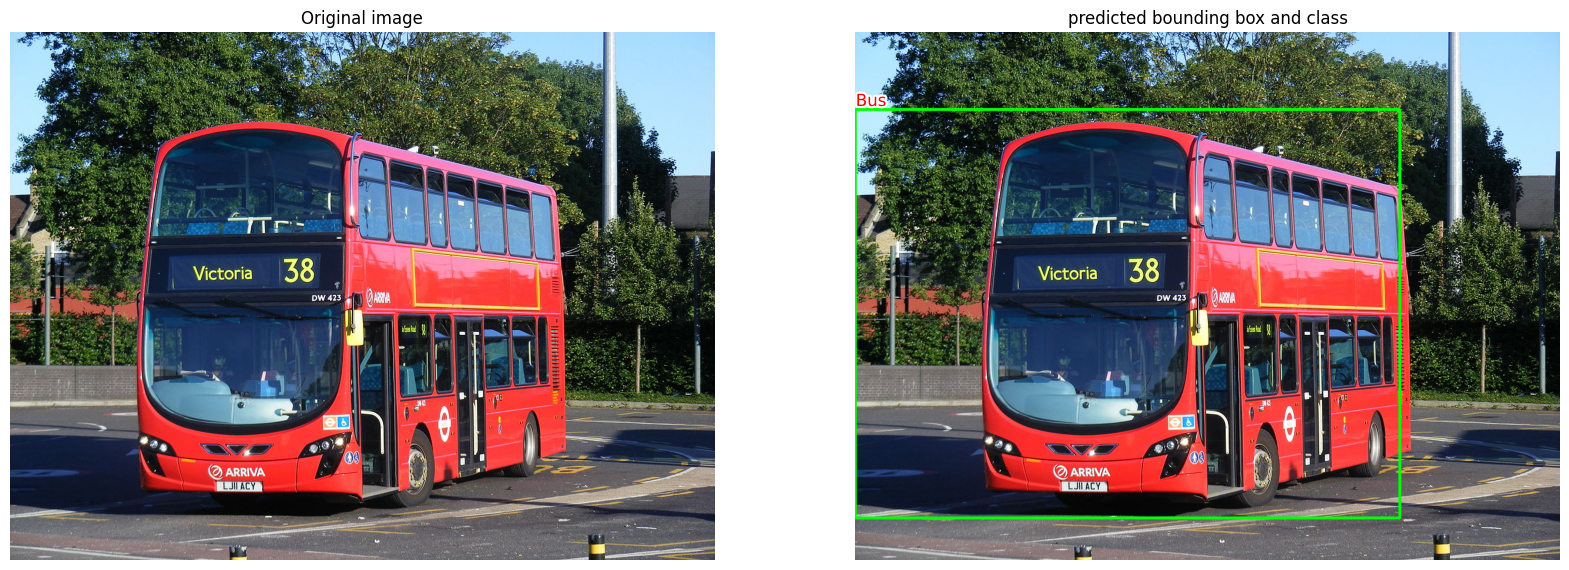

In [54]:
def test_predictions(filename, show_output=True):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape
    candidates = extract_candidates(img)
    candidates = [(x, y, x + w, y + h) for (x, y, w, h) in candidates]
    inputs = []
    for candidate in candidates:
        x, y, X, Y = candidate
        crop = cv2.resize(img[y : Y, x : X], (224, 224))
        inputs.append(preprocess_image(crop / 255.)[[None]])
    
    inputs = torch.cat(inputs).to(device)

    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(inputs)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)

    candidates = np.array(candidates)
    confs, clss, probs, deltas=[tensor.detach().cpu().numpy() \
                              for tensor in [confs, clss, probs, deltas]]
    
    ixs = clss != background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for \
           tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)

    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for \
        tensor in [confs, clss, probs, deltas, candidates, bbs]]

    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = \
            [tensor[None] for tensor in [confs, clss,
            probs, deltas, candidates, bbs]]

    if len(confs) == 0 and not show_output:
        return (0, 0, 224, 224), 'background', 0

    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
        _, ax = plt.subplots(1, 2, figsize=(20,10))

    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    
    ax[1].set_title(label2target[clss[best_pred]])
    show(img, bbs=bbs.tolist(),
        texts=[label2target[c] for c in clss.tolist()],
        ax=ax[1], title='predicted bounding box and class')
    plt.show()
    

test_predictions('./doubledecker.jpg')